In [1]:
import os
import sys
import time
from glob import glob
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

import cv2
from PIL import Image
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# TensorFlow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Set environment settings and pandas display options
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Setting styles
sns.set_style('darkgrid')

# Warning settings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

print('All modules have been imported')


All modules have been imported


In [3]:
import os
import pandas as pd

# Specify the base directory containing all the images
base_folder = r'D:\Main4\dataset_new'

# Read the skin lesions CSV file
csv_file = r"D:\Main4\skin_lesions.csv"
tile_df = pd.read_csv(csv_file)

# Construct the file paths by concatenating the base folder path with the image filenames
tile_df['path'] = base_folder + '/' + tile_df['image_id'] + '.jpg'

# Define the lesion type dictionary
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
    'mel': 'Melanoma',
    'healthy': 'Healthy'  # Assuming 'healthy' represents a class for healthy skin
}

# Map the lesion types to their corresponding labels
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict)

# Convert the lesion type labels to categorical codes
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes

# Display a sample of the DataFrame
tile_df.sample(3)


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
2995,LES_image2996_bkl,image2996,bkl,follow_up,35,male,trunk,D:\Main4\dataset_new/image2996.jpg,Benign keratosis-like lesions,2
6797,LES_image6798_nv,image6798,nv,follow_up,25,male,chest,D:\Main4\dataset_new/image6798.jpg,Melanocytic nevi,5
4251,LES_image4252_healthy,image4252,healthy,confocal,35,male,face,D:\Main4\dataset_new/image4252.jpg,Healthy,4


In [4]:
import pandas as pd

df = pd.DataFrame()

# Assign the 'path' column from tile_df to 'filepaths' column in df
df['filepaths'] = tile_df['path']

# Assign the 'cell_type_idx' column from tile_df to 'labels' column in df
df['labels'] = tile_df['cell_type_idx']

# Convert labels to string type
df['labels'] = df['labels'].astype(str)

df.head()


,filepaths,labels
0,D:\Main4\dataset_new/image0001.jpg,0
1,D:\Main4\dataset_new/image0002.jpg,0
2,D:\Main4\dataset_new/image0003.jpg,0
3,D:\Main4\dataset_new/image0004.jpg,0
4,D:\Main4\dataset_new/image0005.jpg,0


In [5]:
df.labels.unique()

array(['0', '1', '2', '3', '4', '6', '5', '7'], dtype=object)

In [6]:
tile_df['cell_type'].unique()

array(['Actinic keratoses', 'Basal cell carcinoma',
       'Benign keratosis-like lesions', 'Dermatofibroma', 'Healthy',
       'Melanoma', 'Melanocytic nevi', 'Vascular lesions'], dtype=object)

In [7]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=14, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=14, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    return train_df, test_df, valid_df    

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  6400   test_df length:  800   valid_df length:  800


In [8]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes= df[column].unique()
    print(classes)
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=1000
min_samples= 10
column='labels'
train_df, classes, class_count= trim(train_df, max_samples, min_samples, column)

['2' '7' '1' '0' '5' '6' '4' '3']
dataframe initially is of length  6400  with  8  classes
after trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  10
the trimmed dataframe now is of length  6400  with  8  classes


In [9]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

bs=16
ycol='labels'
img_size = (224, 224)  # Define the target size for images

train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_df, test_df, valid_df, img_size)

Found 6400 validated image filenames belonging to 8 classes.           for train generator 
Found 800 validated image filenames belonging to 8 classes.            for valid generator 
Found 800 validated image filenames belonging to 8 classes.            for test generator 
test batch size:  80   test steps:  10  number of classes :  8


In [10]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return


In [12]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable= False
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    # Evidential Begins
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default




Created EfficientNet B3 model with initial learning rate set to 0.001



In [13]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print_in_color(msg)
                comment=input(' ')
                if comment !='':
                    comment = 'User comment: ' + comment
                    print_in_color(comment, (155,245,66))
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

In [15]:
epochs = 25
ask_epoch =25
ask=LR_ASK(model, epochs,  ask_epoch)

In [16]:
history=model.fit(x=train_gen,   epochs=epochs, verbose=1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/25

400/400 [==============================] - 286s 697ms/step - loss: 7.3681 - accuracy: 0.5553 - F1_score: 0.5321 - auc: 0.8741 - val_loss: 5.4531 - val_accuracy: 0.7150 - val_F1_score: 0.6582 - val_auc: 0.9459
Epoch 2/25
400/400 [==============================] - 256s 638ms/step - loss: 4.4818 - accuracy: 0.6817 - F1_score: 0.6399 - auc: 0.9410 - val_loss: 3.4472 - val_accuracy: 0.7688 - val_F1_score: 0.7255 - val_auc: 0.9607
Epoch 3/25
400/400 [==============================] - 503s 1s/step - loss: 2.9202 - accuracy: 0.7345 - F1_score: 0.6770 - auc: 0.9565 - val_loss: 2.3490 - val_accuracy: 0.7563 - val_F1_score: 0.7118 - val_auc: 0.9667
Epoch 4/25
400/400 [==============================] - 301s 753ms/step - loss: 2.0929 - accuracy: 0.7492 - F1_score: 0.6919 - auc: 0.9622 - val_loss: 1.7819 - val_accuracy: 0.7725 - val_F1_score: 0.7293 - val_auc: 0.9667
Epoch 5/25
400/400 [==============================] - 416s 1s/step - loss: 1.6557 - accuracy: 0.7580 - F1_score: 0.7025 - 

In [21]:
import pickle
with open('history[efficientnet_history].pkl','wb') as f:
    pickle.dump(history.history,f)

In [22]:
with open('history[efficientnet_history].pkl', 'rb') as f:
    loaded_history =pickle.load(f)

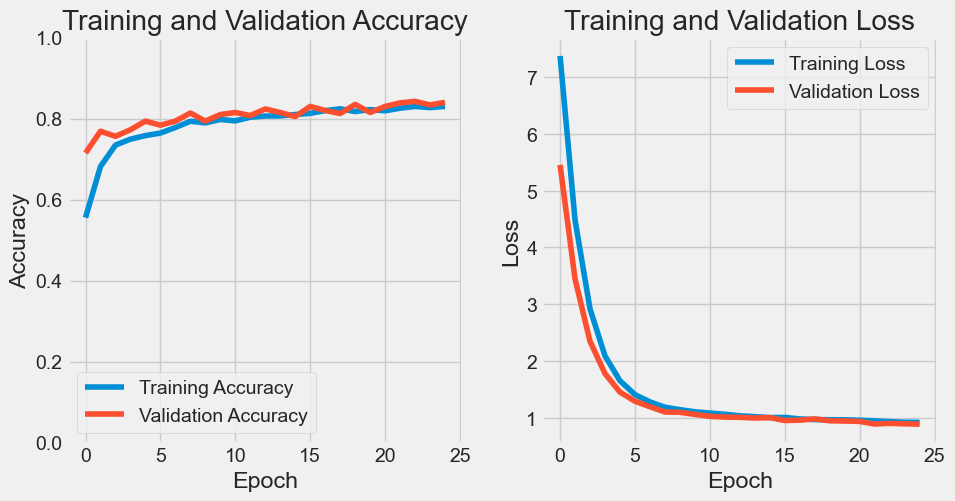

In [23]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

10/10 [==============================] - 30s 2s/step
there were 111 errors in 800 tests for an accuracy of  86.12



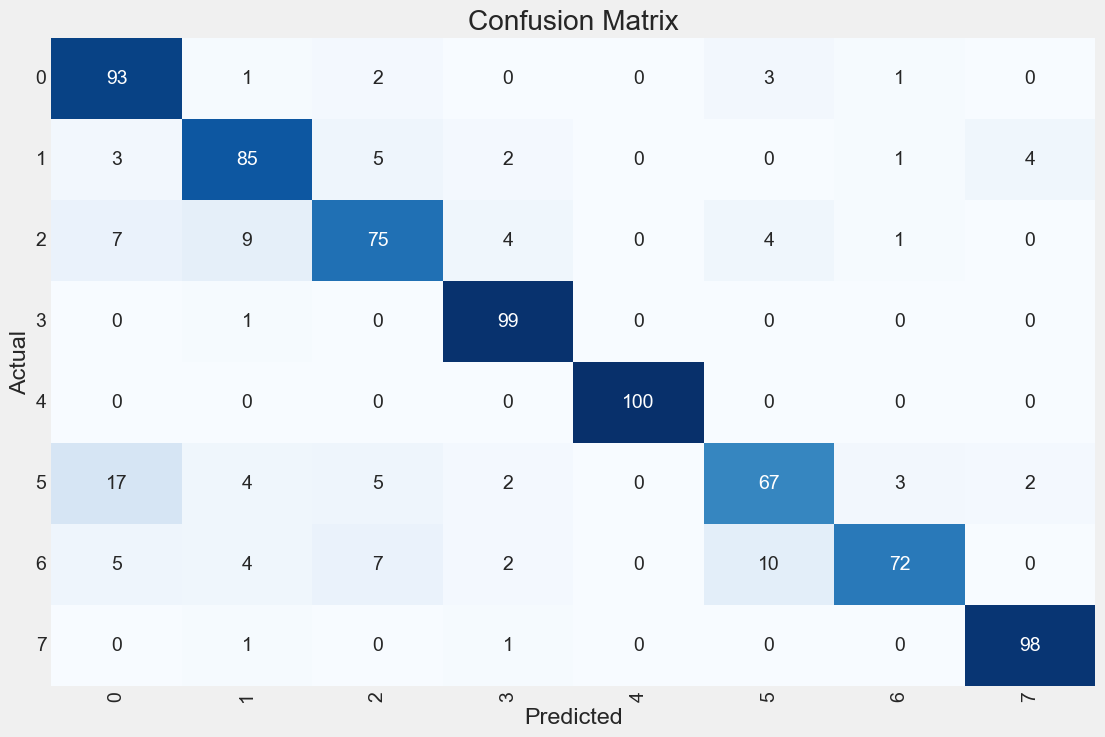

Classification Report:
----------------------
               precision    recall  f1-score   support

           0     0.7440    0.9300    0.8267       100
           1     0.8095    0.8500    0.8293       100
           2     0.7979    0.7500    0.7732       100
           3     0.9000    0.9900    0.9429       100
           4     1.0000    1.0000    1.0000       100
           5     0.7976    0.6700    0.7283       100
           6     0.9231    0.7200    0.8090       100
           7     0.9423    0.9800    0.9608       100

    accuracy                         0.8612       800
   macro avg     0.8643    0.8613    0.8588       800
weighted avg     0.8643    0.8612    0.8588       800



In [24]:
from sklearn.metrics import confusion_matrix 

def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true = predictor(test_gen)

In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0, decode_predictions

def load_and_preprocess_image(image_path, img_size):
    img = keras_image.load_img(image_path, target_size=img_size)
    img_array = keras_image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

def predict_image_class(image_path):
    img_size = (224, 224)  # Assuming the input size of your model is (224, 224)
    image = load_and_preprocess_image(image_path, img_size)
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions)
    # Assuming you have a list or array of class names
    class_names = ["akiec","bcc","bkl","df","healthy","mel","nv","vasc"]  # Replace with your actual class names
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

# Example usage
image_path = r"C:\Users\HP\Desktop\WhatsApp Image 2024-03-24 at 22.36.36_780891c3.jpg"
predicted_class = predict_image_class(image_path)
print("Predicted class:", predicted_class)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\HP\\Desktop\\WhatsApp Image 2024-03-24 at 22.36.36_780891c3.jpg'

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB0, decode_predictions

def load_and_preprocess_image(image_path, img_size):
    img = keras_image.load_img(image_path, target_size=img_size)
    img_array = keras_image.img_to_array(img)
    img_array = preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)

def predict_image_class(image_path):
    img_size = (224, 224)  # Assuming the input size of your model is (224, 224)
    image = load_and_preprocess_image(image_path, img_size)
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions)
    # Assuming you have a list or array of class names
    class_names = ["akiec","bcc","bkl","df","healthy","mel","nv","vasc"]  # Replace with your actual class names
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

# Example usage
image_path = r"C:\Users\HP\Desktop\WhatsApp Image 2024-03-24 at 22.36.36_780891c3.jpg"
predicted_class = predict_image_class(image_path)
print("Predicted class:", predicted_class)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\HP\\Desktop\\WhatsApp Image 2024-03-24 at 22.36.36_780891c3.jpg'

In [19]:
model.save('efficientnetfreezedepoch25.h5')